In [27]:
# Cell 1 - imports & config
import os
import warnings
os.environ["OMP_NUM_THREADS"] = "1"   # reduce MKL/KMeans warnings on Windows
warnings.filterwarnings("ignore")

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
# Try to import xgboost if available (recommended)
USE_XGBOOST = True
try:
    import xgboost as xgb
except Exception:
    USE_XGBOOST = False
    print("xgboost not available; skipping XGBoost models.")

# CONFIG - change these paths to match your environment
FEATURE_DIR = "data/gmm_benchmark"   # folder where GMM outputs are saved
LABELED_CSV = os.path.join(FEATURE_DIR, "features_master_labeled_with_tentative.csv")
OUT_DIR = r"data/ml_models"
os.makedirs(OUT_DIR, exist_ok=True)

# Recommended choices
RECOMMENDED = {
    "exclude_tentative": True,   # recommended: exclude _TENTATIVE samples during ML training
    "lopo_required_min_players": 2,   # min players to attempt LOPO
    "min_class_count_for_stratify": 2, # min samples per class to do stratified split
    "random_state": 42,
    "rf_n_estimators": 500,
    "rf_class_weight": "balanced",     # helps with class imbalance
    "svm_prob": False,                 # set True if you want probabilities (slower)
    "knn_k": 5,
    "test_size_quick": 0.2
}

print("LABELED_CSV:", LABELED_CSV)
print("OUT_DIR:", OUT_DIR)
print("USE_XGBOOST:", USE_XGBOOST)


LABELED_CSV: data/gmm_benchmark\features_master_labeled_with_tentative.csv
OUT_DIR: data/ml_models
USE_XGBOOST: True


In [28]:
# Cell 2 - load data and prepare X, y, players
df = pd.read_csv(LABELED_CSV)
print("Loaded df:", df.shape)
print("Columns sample:", df.columns.tolist()[:40])

# Recommended: exclude _TENTATIVE samples for reliable training
if RECOMMENDED["exclude_tentative"]:
    mask = ~df['performance_level_adjusted'].astype(str).str.endswith("_TENTATIVE")
    df_ml = df[mask].reset_index(drop=True)
    print("Excluding tentative samples. New shape:", df_ml.shape)
else:
    df_ml = df.copy()
    print("Including tentative samples. Shape:", df_ml.shape)

# Auto-select feature columns (same keywords as clustering)
AUTO_FEATURE_KEYWORDS = ["__rms","__peak","__iEMG","__mnf","__mdf","__time_to_peak","__dur_halfmax",
                         "__mrms_mean","__mrms_peak","coact","lr_mean_ratio","__std","__wl"]

candidate_cols = [c for c in df_ml.columns if any(kw in c.lower() for kw in AUTO_FEATURE_KEYWORDS)]
if len(candidate_cols) == 0:
    # fallback: use numeric columns excluding metadata
    exclude = {'file','player','n_samples','fs_used','gmm_label','gmm_confidence','performance_level','performance_level_confidence','performance_level_adjusted','_proxy_score'}
    candidate_cols = [c for c in df_ml.columns if c not in exclude and np.issubdtype(df_ml[c].dtype, np.number)]

print("Using", len(candidate_cols), "feature columns for ML.")
print(candidate_cols[:40])

# Build arrays
X_full = df_ml[candidate_cols].copy().fillna(df_ml[candidate_cols].median()).values.astype(float)
y_full = df_ml['performance_level_adjusted'].astype(str).values
players_full = df_ml['player'].astype(str).values

# Encode labels to integers for metrics convenience
le = LabelEncoder()
y_enc = le.fit_transform(y_full)
class_names = list(le.classes_)
print("Classes:", class_names)
print("Players (unique):", np.unique(players_full).tolist())


Loaded df: (35, 200)
Columns sample: ['file', 'player', 'n_samples', 'fs_used', 'Rectus Femoris right__mean', 'Rectus Femoris right__std', 'Rectus Femoris right__rms', 'Rectus Femoris right__rms_rel', 'Rectus Femoris right__mav', 'Rectus Femoris right__mav_rel', 'Rectus Femoris right__wl', 'Rectus Femoris right__peak', 'Rectus Femoris right__peak_rel', 'Rectus Femoris right__iEMG', 'Rectus Femoris right__iEMG_rel', 'Rectus Femoris right__mnf', 'Rectus Femoris right__mdf', 'Rectus Femoris right__bp_20_60', 'Rectus Femoris right__bp_60_100', 'Rectus Femoris right__bp_100_200', 'Rectus Femoris right__time_to_peak_s', 'Rectus Femoris right__dur_halfmax_s', 'Rectus Femoris right__mrms_mean', 'Rectus Femoris right__mrms_mean_rel', 'Rectus Femoris right__mrms_peak', 'Rectus Femoris right__mrms_peak_rel', 'Rectus Femoris left__mean', 'Rectus Femoris left__std', 'Rectus Femoris left__rms', 'Rectus Femoris left__rms_rel', 'Rectus Femoris left__mav', 'Rectus Femoris left__mav_rel', 'Rectus Femori

In [29]:
# Cell 3 - helpers: metrics and model factory
def compute_metrics(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prf = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    per_class = {}
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    for i, lab in enumerate(labels):
        per_class[lab] = {
            "precision": float(prf[0][i]),
            "recall": float(prf[1][i]),
            "f1": float(prf[2][i]),
            "support": int(prf[3][i])
        }
    return {"accuracy": float(acc), "f1_macro": float(f1_macro), "per_class": per_class}

def save_model(obj, path):
    import joblib
    joblib.dump(obj, path)
    print("Saved:", path)

def get_base_models(random_state=42):
    models = {}
    # Random Forest
    models['rf'] = RandomForestClassifier(n_estimators=RECOMMENDED['rf_n_estimators'],
                                          class_weight=RECOMMENDED['rf_class_weight'],
                                          random_state=random_state,
                                          n_jobs=-1)
    # Logistic Regression (multinomial)
    models['lr'] = LogisticRegression(multi_class='multinomial', max_iter=2000, class_weight='balanced', random_state=random_state)
    # SVM (RBF)
    models['svm'] = SVC(kernel='rbf', probability=RECOMMENDED['svm_prob'], class_weight='balanced', random_state=random_state)
    # k-NN
    models['knn'] = KNeighborsClassifier(n_neighbors=RECOMMENDED['knn_k'])
    # XGBoost (if available)
    if USE_XGBOOST:
        xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=len(class_names),
                                    n_estimators=200, use_label_encoder=False, eval_metric='mlogloss',
                                    random_state=random_state, verbosity=0)
        models['xgb'] = xgb_clf
    return models

models = get_base_models(random_state=RECOMMENDED['random_state'])
print("Models:", list(models.keys()))


Models: ['rf', 'lr', 'svm', 'knn', 'xgb']


In [30]:
# Cell 4 - validation decision & LOPO function
unique_players = np.unique(players_full)
n_players = len(unique_players)
n_samples = X_full.shape[0]
print("n_samples:", n_samples, "n_players:", n_players)

# Check class counts
class_counts = pd.Series(y_full).value_counts().to_dict()
print("Class counts:", class_counts)

# Decision logic:
use_lopo = (n_players >= RECOMMENDED["lopo_required_min_players"] and n_players >= 2)
# check whether stratified split is allowed: every class must have >= min_class_count_for_stratify
can_stratify = all([count >= RECOMMENDED["min_class_count_for_stratify"] for count in class_counts.values()])

print("use_lopo:", use_lopo, "can_stratify:", can_stratify)

# LOPO evaluation function
def lopo_evaluate(models_dict, X, y_enc, players, feature_cols, le):
    """
    Performs LOPO per model; returns per-model aggregated metrics and predictions.
    """
    results = {name: {"folds": [], "y_true_all": [], "y_pred_all": []} for name in models_dict.keys()}
    for test_player in np.unique(players):
        idx_test = np.where(players == test_player)[0]
        idx_train = np.where(players != test_player)[0]
        if len(idx_test) == 0 or len(idx_train) == 0:
            continue
        Xtr, Xte = X[idx_train], X[idx_test]
        ytr, yte = y_enc[idx_train], y_enc[idx_test]
        # scale per-fold
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)
        for name, clf in models_dict.items():
            # clone to avoid state leakage
            from sklearn.base import clone
            clf_local = clone(clf)
            clf_local.fit(Xtr_s, ytr)
            ypred = clf_local.predict(Xte_s)
            # store
            results[name]["folds"].append({
                "test_player": test_player,
                "n_test": int(len(yte)),
                "accuracy": float(accuracy_score(yte, ypred)),
                "f1_macro": float(f1_score(yte, ypred, average='macro', zero_division=0))
            })
            results[name]["y_true_all"].extend(list(yte))
            results[name]["y_pred_all"].extend(list(ypred))
            # optionally save per-fold model & scaler
            fold_model_path = os.path.join(OUT_DIR, f"{name}_lopo_model_testplayer_{test_player}.joblib")
            fold_scaler_path = os.path.join(OUT_DIR, f"{name}_lopo_scaler_testplayer_{test_player}.joblib")
            save_model(clf_local, fold_model_path)
            save_model(scaler, fold_scaler_path)
    # aggregate
    for name in results.keys():
        ytrue = np.array(results[name]["y_true_all"])
        ypred = np.array(results[name]["y_pred_all"])
        if ytrue.size > 0:
            results[name]["aggregate"] = compute_metrics(ytrue, ypred, labels=np.unique(np.concatenate([ytrue, ypred])))
        else:
            results[name]["aggregate"] = None
    return results

# Run chosen strategy
if use_lopo and n_players >= 2:
    print("Running LOPO evaluation...")
    lopo_results = lopo_evaluate(models, X_full, y_enc, players_full, candidate_cols, le)
else:
    # fallback to stratified split if possible, else debug train-on-all
    if can_stratify and n_samples >= 4:
        print("Using stratified train/test split (quick check).")
        Xtr, Xte, ytr, yte = train_test_split(X_full, y_enc, test_size=RECOMMENDED['test_size_quick'],
                                               stratify=y_enc, random_state=RECOMMENDED['random_state'])
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)
        strat_results = {}
        for name, clf in models.items():
            from sklearn.base import clone
            clf_local = clone(clf)
            clf_local.fit(Xtr_s, ytr)
            ypred = clf_local.predict(Xte_s)
            strat_results[name] = {
                "accuracy": float(accuracy_score(yte, ypred)),
                "f1_macro": float(f1_score(yte, ypred, average='macro', zero_division=0)),
                "report": classification_report(yte, ypred, zero_division=0, target_names=le.inverse_transform(sorted(np.unique(np.concatenate([yte, ypred])))))
            }
            # save model & scaler
            save_model(clf_local, os.path.join(OUT_DIR, f"{name}_strat_final.joblib"))
            save_model(scaler, os.path.join(OUT_DIR, f"{name}_strat_scaler.joblib"))
        print("Stratified-split results (quick):")
        for k,v in strat_results.items():
            print(k, "acc:", v['accuracy'], "f1:", v['f1_macro'])
    else:
        # debug fallback: train & test on same data (not valid for reporting)
        print("Not enough data for LOPO or stratified split. Using DEBUG train-on-all (ONLY for pipeline testing).")
        debug_results = {}
        scaler = StandardScaler().fit(X_full)
        Xs = scaler.transform(X_full)
        for name, clf in models.items():
            from sklearn.base import clone
            clf_local = clone(clf)
            clf_local.fit(Xs, y_enc)
            ypred = clf_local.predict(Xs)
            debug_results[name] = {
                "accuracy": float(accuracy_score(y_enc, ypred)),
                "f1_macro": float(f1_score(y_enc, ypred, average='macro', zero_division=0)),
                "report": classification_report(y_enc, ypred, zero_division=0, target_names=le.inverse_transform(sorted(np.unique(np.concatenate([y_enc, ypred])))))
            }
            save_model(clf_local, os.path.join(OUT_DIR, f"{name}_debug_final.joblib"))
            save_model(scaler, os.path.join(OUT_DIR, f"{name}_debug_scaler.joblib"))
        print("Debug results (train==test):")
        for k,v in debug_results.items():
            print(k, "acc:", v['accuracy'], "f1:", v['f1_macro'])


n_samples: 35 n_players: 1
Class counts: {'Excellent': 10, 'Poor': 10, 'Below-Average': 9, 'Average': 6}
use_lopo: False can_stratify: True
Using stratified train/test split (quick check).
Saved: data/ml_models\rf_strat_final.joblib
Saved: data/ml_models\rf_strat_scaler.joblib
Saved: data/ml_models\lr_strat_final.joblib
Saved: data/ml_models\lr_strat_scaler.joblib
Saved: data/ml_models\svm_strat_final.joblib
Saved: data/ml_models\svm_strat_scaler.joblib
Saved: data/ml_models\knn_strat_final.joblib
Saved: data/ml_models\knn_strat_scaler.joblib
Saved: data/ml_models\xgb_strat_final.joblib
Saved: data/ml_models\xgb_strat_scaler.joblib
Stratified-split results (quick):
rf acc: 1.0 f1: 1.0
lr acc: 1.0 f1: 1.0
svm acc: 1.0 f1: 1.0
knn acc: 1.0 f1: 1.0
xgb acc: 0.8571428571428571 f1: 0.8666666666666667


In [31]:
# Cell 5 - aggregate & display results from LOPO (if present)
if 'lopo_results' in globals():
    summary_rows = []
    for name, res in lopo_results.items():
        agg = res.get("aggregate")
        if agg is None:
            summary_rows.append({"model": name, "accuracy": None, "f1_macro": None})
        else:
            summary_rows.append({"model": name, "accuracy": agg['accuracy'], "f1_macro": agg['f1_macro']})
    cmp_df = pd.DataFrame(summary_rows).sort_values('f1_macro', ascending=False)
    display(cmp_df)
    # Print classification reports for best model
    best_model_name = cmp_df.iloc[0]['model']
    print("Best model by LOPO f1_macro:", best_model_name)
    y_true = np.array(lopo_results[best_model_name]['y_true_all'])
    y_pred = np.array(lopo_results[best_model_name]['y_pred_all'])
    if y_true.size > 0:
        print("Classification report (aggregated LOPO):")
        print(classification_report(y_true, y_pred, zero_division=0, target_names=le.inverse_transform(sorted(np.unique(np.concatenate([y_true, y_pred]))))))
        cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(np.concatenate([y_true, y_pred]))))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.inverse_transform(sorted(np.unique(np.concatenate([y_true, y_pred])))), yticklabels=le.inverse_transform(sorted(np.unique(np.concatenate([y_true, y_pred])))))
        plt.title(f"LOPO Confusion Matrix - {best_model_name}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()
    # save aggregated results
    with open(os.path.join(OUT_DIR, "lopo_summary.json"), "w") as f:
        json.dump({k: (v['aggregate'] if v['aggregate'] is not None else {}) for k,v in lopo_results.items()}, f, indent=2)
    print("Saved LOPO summary to", os.path.join(OUT_DIR, "lopo_summary.json"))


In [32]:
# Cell 6 - train final models on full available (after excluding tentative if chosen)
# This is the model you'll deploy; training on all data uses the known labels.
scaler_final = StandardScaler().fit(X_full)
X_all_scaled = scaler_final.transform(X_full)

final_models = {}
for name, clf in models.items():
    from sklearn.base import clone
    clf_local = clone(clf)
    clf_local.fit(X_all_scaled, y_enc)
    final_models[name] = clf_local
    # save final model + scaler + features
    save_model(clf_local, os.path.join(OUT_DIR, f"{name}_final.joblib"))
    save_model(scaler_final, os.path.join(OUT_DIR, f"{name}_final_scaler.joblib"))

# save label encoder and feature list
save_model(le, os.path.join(OUT_DIR, "label_encoder.joblib"))
pd.Series(candidate_cols).to_csv(os.path.join(OUT_DIR, "feature_columns.csv"), index=False)
print("Saved final models and artifacts to", OUT_DIR)


Saved: data/ml_models\rf_final.joblib
Saved: data/ml_models\rf_final_scaler.joblib
Saved: data/ml_models\lr_final.joblib
Saved: data/ml_models\lr_final_scaler.joblib
Saved: data/ml_models\svm_final.joblib
Saved: data/ml_models\svm_final_scaler.joblib
Saved: data/ml_models\knn_final.joblib
Saved: data/ml_models\knn_final_scaler.joblib
Saved: data/ml_models\xgb_final.joblib
Saved: data/ml_models\xgb_final_scaler.joblib
Saved: data/ml_models\label_encoder.joblib
Saved final models and artifacts to data/ml_models


,feature,importance
0,Rectus Femoris right__peak_rel,0.033791
1,Gastrocnemius__LR_mean_ratio,0.032499
2,Gastrocnemius left__mrms_mean,0.029418
3,Rectus Femoris right__rms,0.026379
4,Hamstrings left__mrms_mean,0.024644
5,Rectus Femoris right__peak,0.024445
6,Hamstrings left__std,0.022884
7,Rectus Femoris right__mrms_peak,0.022435
8,Hamstrings left__rms_rel,0.020437
9,Rectus Femoris right__std,0.019844


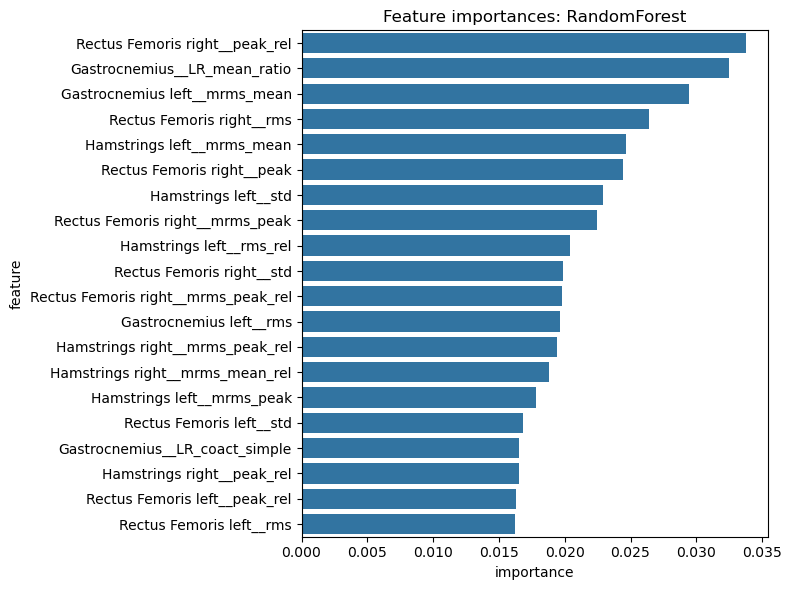

,feature,importance
0,TibilaisÂ Anterior left__std,0.155912
1,Gastrocnemius left__time_to_peak_s,0.101779
2,Hamstrings left__std,0.093293
3,Rectus Femoris right__std,0.092651
4,Rectus Femoris right__peak_rel,0.082831
5,TibilaisÂ Anterior right__wl,0.063962
6,Hamstrings right__mrms_mean_rel,0.059575
7,Rectus Femoris left__rms,0.059190
8,TibilaisÂ Anterior right__std,0.055166
9,TibilaisÂ Anterior__LR_coact_simple,0.050010


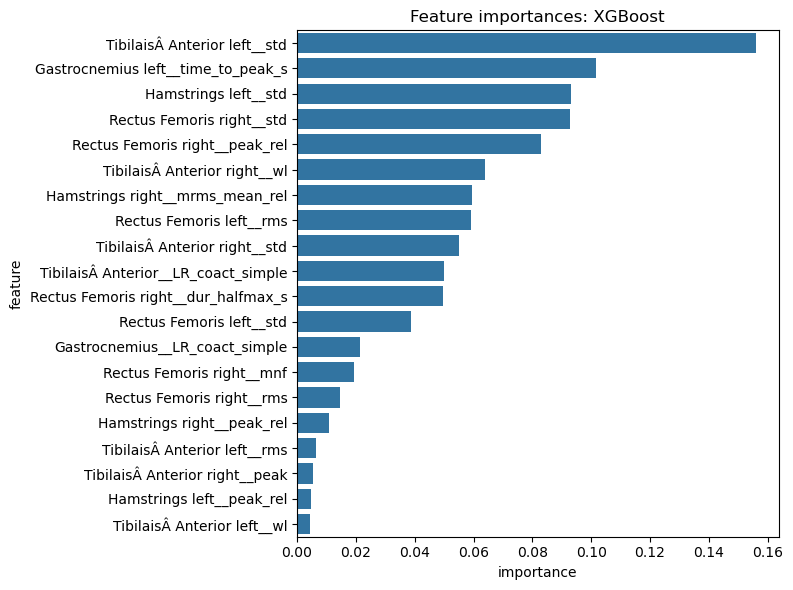

In [33]:
# Cell 7 - feature importance for tree-based models (RF & XGB)
def show_feature_importances(clf, name, feature_cols, top_n=30):
    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        imp_df = pd.DataFrame({"feature": feature_cols, "importance": imp}).sort_values("importance", ascending=False).reset_index(drop=True)
        display(imp_df.head(top_n))
        plt.figure(figsize=(8,6))
        sns.barplot(x="importance", y="feature", data=imp_df.head(min(top_n,len(feature_cols))))
        plt.title(f"Feature importances: {name}")
        plt.tight_layout()
        plt.show()
    else:
        print(name, "has no attribute feature_importances_")

if 'rf' in final_models:
    show_feature_importances(final_models['rf'], 'RandomForest', candidate_cols, top_n=20)
if USE_XGBOOST and 'xgb' in final_models:
    show_feature_importances(final_models['xgb'], 'XGBoost', candidate_cols, top_n=20)


In [34]:
# Cell 8 - save per-model evaluation artifacts
def save_confusion_and_report(y_true, y_pred, model_name, le, out_dir):
    labels_sorted = sorted(np.unique(np.concatenate([y_true, y_pred])))
    target_names = le.inverse_transform(labels_sorted)
    report_text = classification_report(y_true, y_pred, zero_division=0, target_names=target_names)
    with open(os.path.join(out_dir, f"{model_name}_classification_report.txt"), "w") as f:
        f.write(report_text)
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.savefig(os.path.join(out_dir, f"{model_name}_confusion.png"), bbox_inches='tight', dpi=200)
    plt.close()
    print("Saved report and confusion for", model_name)

# If LOPO ran, save aggregated reports per model
if 'lopo_results' in globals():
    for name, res in lopo_results.items():
        ytrue = np.array(res['y_true_all'])
        ypred = np.array(res['y_pred_all'])
        if ytrue.size > 0:
            save_confusion_and_report(ytrue, ypred, f"LOPO_{name}", le, OUT_DIR)

# If stratified run, save strat results
if 'strat_results' in globals():
    for name, v in strat_results.items():
        # the text report is in v['report']
        with open(os.path.join(OUT_DIR, f"STRAT_{name}_report.txt"), "w") as f:
            f.write(v['report'])
        print("Saved strat report for", name)

# If debug run, save debug reports
if 'debug_results' in globals():
    for name, v in debug_results.items():
        with open(os.path.join(OUT_DIR, f"DEBUG_{name}_report.txt"), "w") as f:
            f.write(v['report'])
        print("Saved debug report for", name)


Saved strat report for rf
Saved strat report for lr
Saved strat report for svm
Saved strat report for knn
Saved strat report for xgb
